In [26]:
import quimb as qu
from quimb.experimental.cluster_update.cxu import ClusterUpdateGen
from vmc_torch.fermion_utils import generate_random_fpeps
import quimb.tensor as qtn
import quimb as qu
import symmray as sr
import pickle

In [13]:

# Define the lattice shape
Lx = 4
Ly = 4
spinless = False
N = int(Lx * Ly)
# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly)

# SU in quimb
D = 2
seed = 2
symmetry = 'Z2'
spinless = False
fpeps = generate_random_fpeps(Lx, Ly, D=D, seed=42, symmetry=symmetry, Nf=N_f, spinless=spinless)[0]
edges = qtn.edges_2d_square(Lx, Ly, cyclic=False)
try:
    parse_edges_to_site_info = sr.utils.parse_edges_to_site_info
except AttributeError:
    parse_edges_to_site_info = sr.parse_edges_to_site_info
site_info = parse_edges_to_site_info(
    edges,
    D,
    phys_dim=4,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

t = 1.0
U = 8.0
if N_f == int(Lx*Ly-2) or N_f == int(Lx*Ly-8):
    mu = 0.0 if symmetry == 'U1' else (U*N_f/(2*N)-2.42)#(U*N_f/(2*N)-2.3)
elif N_f == int(Lx*Ly):
    mu = 0.0 if symmetry == 'U1' else (U/2)
elif N_f == int(Lx*Ly-4):
    mu = 0.0 if symmetry == 'U1' else (U*N_f/(2*N)-2.46)
else:
    mu = 0.0

print(mu)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb) in fpeps.gen_bond_coos()
}
N_terms = {
    site: sr.fermi_number_operator_spinful_local_array(
        symmetry=symmetry
    )
    for site in fpeps.gen_site_coos()
}
occ_fn = lambda su: print(f'N per site:{su.get_state().compute_local_expectation(N_terms, normalized=True, max_bond=64,)/N}') if su.n%50==0 else None
density = False
ham = qtn.LocalHam2D(Lx, Ly, terms)

def compute_energy(psi, gauges, method="boundary", max_bond=None):
    psi = psi.copy()

    if method == "cluster":
        gauges = gauges.copy()
        psi.gauge_all_simple_(100, 1e-6, gauges=gauges)
        return psi.compute_local_expectation_cluster(
            ham.terms,
            max_distance=0,
            normalized=True,
            gauges=gauges,
            optimize="auto-hq",
        ) / psi.nsites

    psi = psi.copy()
    if gauges is not None:
        psi.gauge_simple_insert(gauges)

    if method == "exact" or psi.nsites <= 20:
        psi.contract_(all, optimize="auto-hq")
        return psi.compute_local_expectation_exact(ham.terms) / psi.nsites

    if method == "boundary":

        if max_bond is None:
            max_bond = max(16, psi.max_bond()**2)

        return psi.compute_local_expectation(
            ham.terms,
            max_bond=max(16, psi.max_bond()**2),
            equalize_norms=1.0,
            normalized=True,
            layer_tags=None, mode="fit-zipup", bsz=1,
        ) / psi.nsites

4.0


In [21]:
su = qtn.SimpleUpdateGen(
    fpeps, 
    ham, 
    compute_energy_per_site=True, 
    compute_energy_every=25,
    second_order_reflect=True,
    ordering="smallest_last",
    # compute_energy_opts={"max_distance":1}, 
    # gate_opts={'cutoff':1e-12}, 
    tol=1e-7,
    callback=occ_fn if density else None,
    plot_every=25,
)

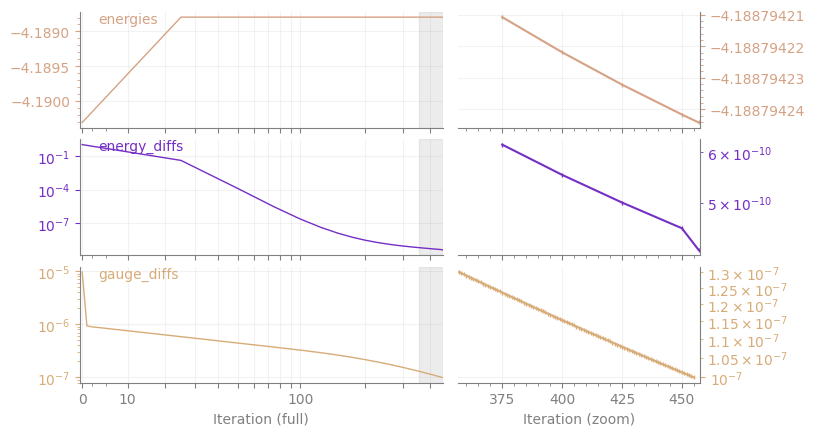

n=457, D=2, tau=0.01, max|dS|=9.99e-08, energy≈-4.18879:  91%|#########1| 457/500 [01:57<00:11,  3.90it/s]


fPEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=2)

In [22]:
# cluster energies may not be accuracte yet
# su.evolve(1000, tau=0.1)
su.evolve(500, tau=0.01)
# su.evolve(50, tau=0.03)
# su.evolve(50, tau=0.01)
# su.evolve(50, tau=0.003)

fpeps = su.get_state()
fpeps.equalize_norms_(value=1)

In [24]:
psi = su.get_state()

In [29]:
# imaginary time step
tau = D**-1.5 / 2

# control how the local cluster is generated
# generate generalized loops (gloop) and take their union
mode = "loopunion"
# maximum size for each gloop
max_distance = 4
# how gloop is related to target sites:
# this means each gloop must contain all target sites,
# but the target sites can be dangling (1-degree connected)
grow_from = "alldangle"

# max_distance = 4:
#
#    gloop1      gloop2   union->cluster
#     |  |                        |  |
#    -o--o-                      -o--o-
#     |  |                        |  |
#    -A--B-   +   -A--B-    =    -A--B-
#     |  |         |  |           |  |
#                 -o--o-         -o--o-
#                  |  |           |  |
#
# max_distance = 5:
#
#    gloop 1                 union->cluster
#      |  |                          |  |  |  |
#     -o--o-                        -o--o--o--o-
#      |  |  |                       |  |  |  |
#     -o--A--B-   +    ...      =   -o--A--B--o-
#      |  |  |                       |  |  |  |
#                                   -o--o--o--o-
#    (size 5 with B dangling)        |  |  |  |
#

# no point in less than this for single precision
tol = 1e-7

In [30]:
cu = ClusterUpdateGen(
    psi,
    ham,
    max_distance=max_distance,
    grow_from=grow_from,
    mode=mode,
    # each gate environment is computed from previous layer
    update="parallel",
    gauge_power=1.0,
    cutoff=0.0,
    second_order_reflect=True,
    gate_opts=dict(
        max_iterations=100,
        tol=tol,
        solver="solve",
        prenormalize=True,
        condition=True,
        enforce_pos=True,
        pos_smudge=tol,
        gauge_smudge=tol,
        init="svd",
    ),
    ordering="sort",
    equilibrate_every=(
        # 0
        # "gate"
        "layer"
        # "sweep"
        # 2
    ),
    equilibrate_opts=dict(
        max_iterations=256,
        tol=tol,
        progbar=False,
    ),
    compute_energy_fn=lambda cu: compute_energy(cu._psi, cu.gauges),
    compute_energy_every=5,
    plot_every=5,
    tol=tol,
    tol_energy_diff=tol / 10,
    keep_best=True,
)

In [ ]:
cu.evolve(
    100,
    tau=tau,
    progbar=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]